In [3]:
import time
import warnings
from itertools import cycle, islice

import matplotlib.pyplot as plt
import numpy as np

from sklearn import cluster
from sklearn.preprocessing import StandardScaler

from src.utilities.helper import get_datasets, get_best_params


In [4]:
import pandas as pd
# Read the clustering results
df = pd.read_csv('clustering_tuning_results.csv')


default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 3,
    "n_clusters": 3,
    "min_samples": 7,
    "xi": 0.05,
    "min_cluster_size": 0.1,
    "allow_single_cluster": True,
    "hdbscan_min_cluster_size": 15,
    "hdbscan_min_samples": 3,
    "random_state": 42,
    
    # ------------------------------------------------------------------------------------------------------------------
    "modularity_neighbors": 15,
    "resolution": 0.001,
    "lambda": 10,
    # ------------------------------------------------------------------------------------------------------------------
}

datasets = get_datasets()

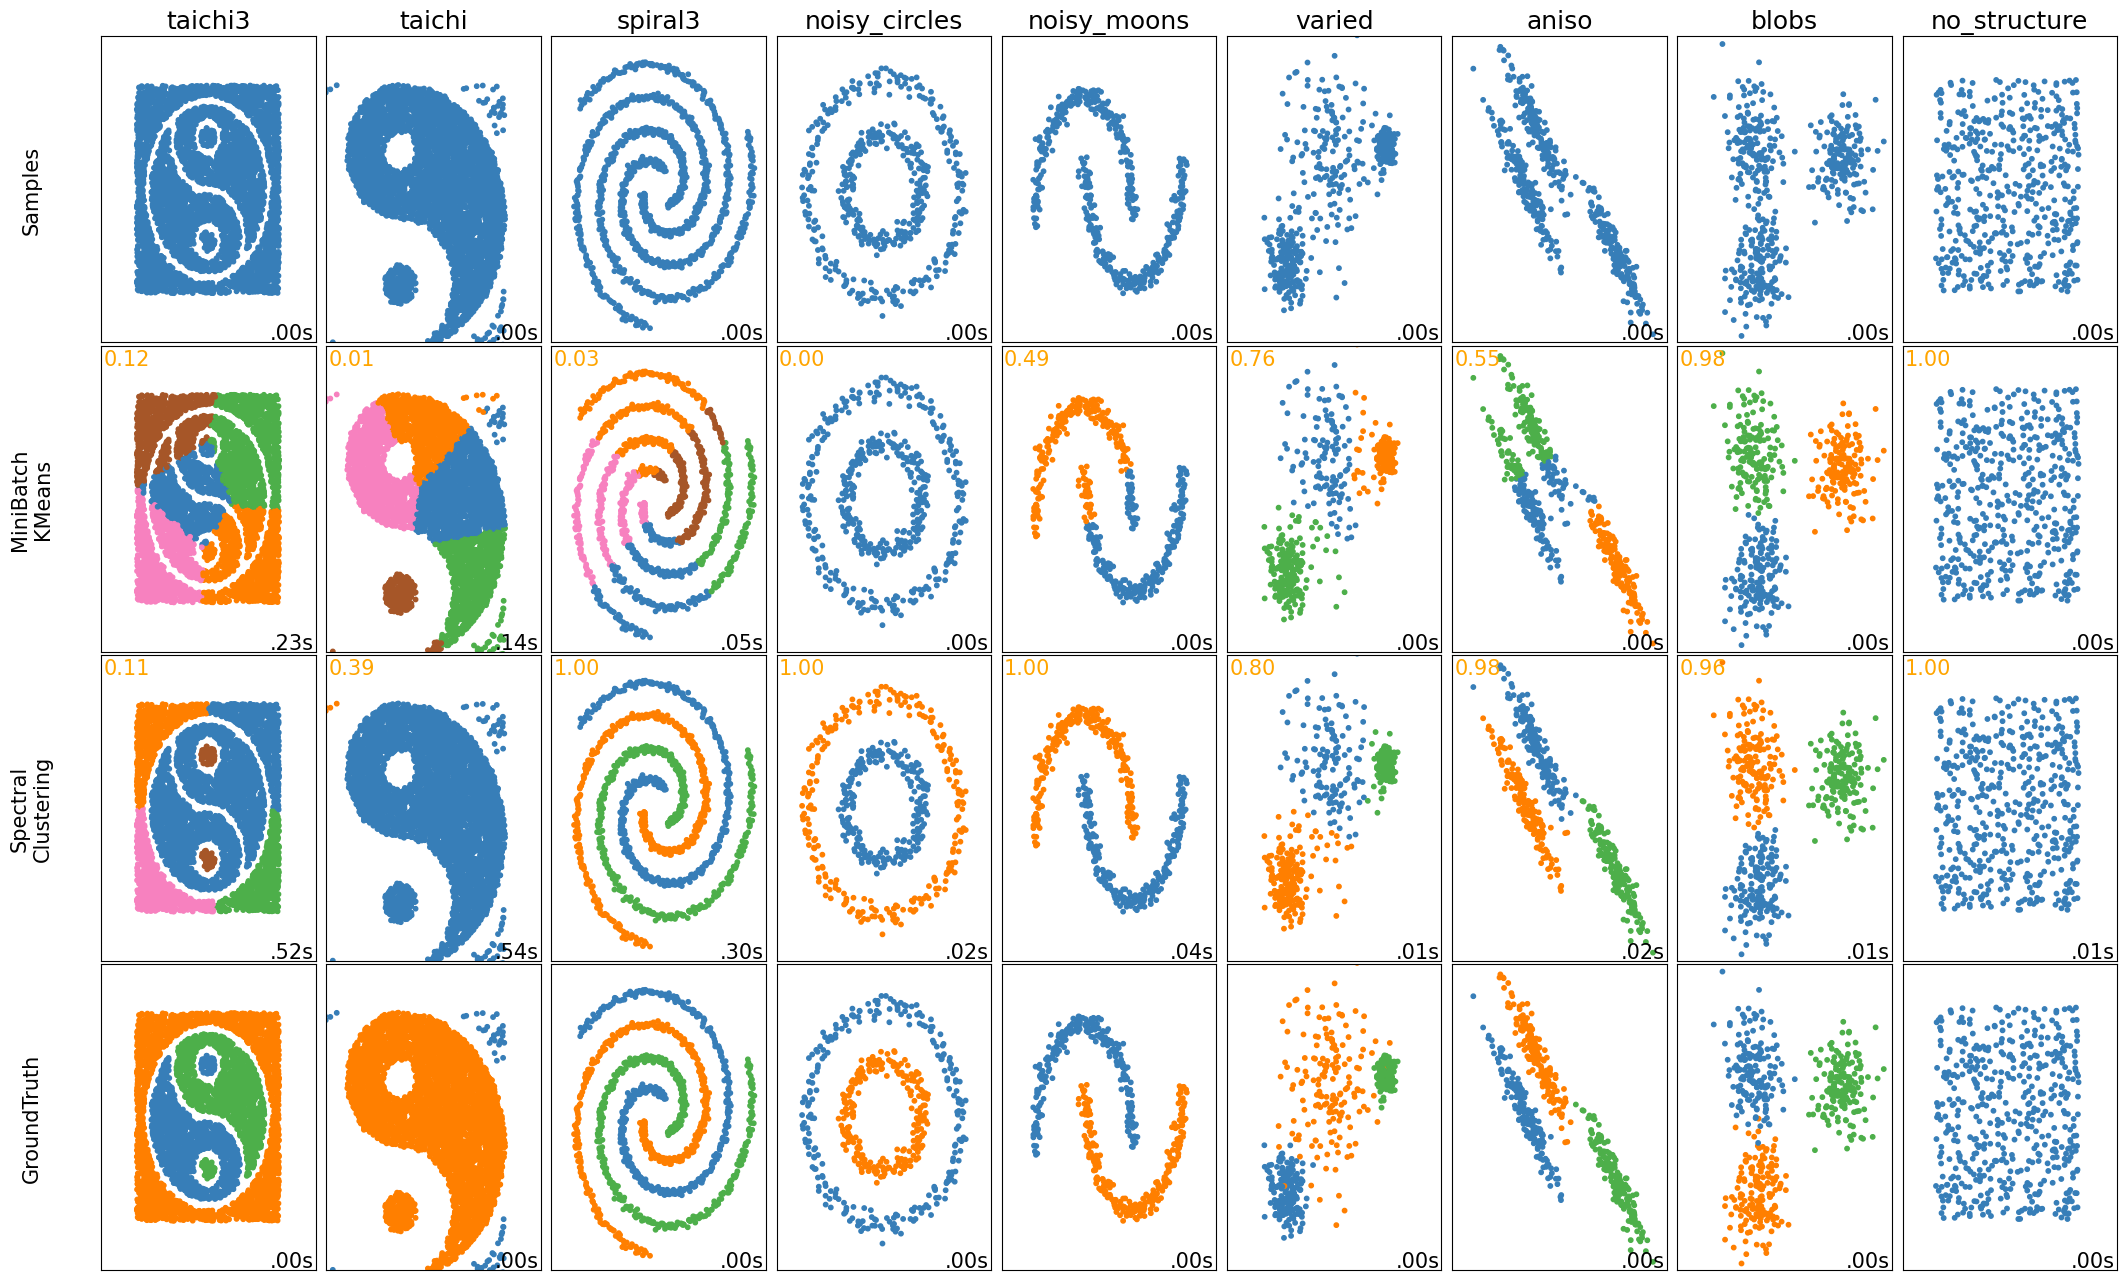

In [5]:
from sklearn.metrics import adjusted_rand_score

plt.figure(figsize=(9 * 2 + 3, 13))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)

plot_num = 1

for i_dataset, (dataset_name, dataset) in enumerate(datasets):
    # update parameters with dataset-specific values
    params = default_base.copy()
    # params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)
    # ============
    # Create cluster objects
    # ============
    tm_params = get_best_params(df, dataset_name, "MiniBatchKMeans")['params']
    params.update(tm_params)
    two_means = cluster.MiniBatchKMeans(
        n_clusters=params["n_clusters"],
        random_state=params["random_state"],
    )
    
    sc_params = get_best_params(df, dataset_name, "SpectralClustering")['params']
    params.update(sc_params)
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
        random_state=params["random_state"],
    )
    
    clustering_algorithms = (
        # ------------------------------------------------------------------------------------------------------------------
        ("Samples", None),

        # ------------------------------------------------------------------------------------------------------------------
        ("MiniBatch\nKMeans", two_means),
        # ("Affinity\nPropagation", affinity_propagation),
        # ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        # ("Ward", ward),
        # ("Agglomerative\nClustering", average_linkage),
        # ("DBSCAN", dbscan),
        # ("HDBSCAN", hdbscan),
        # ("OPTICS", optics),
        # ("BIRCH", birch),
        # ("Gaussian\nMixture", gmm),
        
        # ------------------------------------------------------------------------------------------------------------------
        # ("Modularity\n(kNN+Leiden)", leiden),
        ("GroundTruth", None),
        # ------------------------------------------------------------------------------------------------------------------
    )

    for i_algo, (name, algorithm) in enumerate(clustering_algorithms):
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            # ------------------------------------------------------------------------------------------------------------------
            if name != "GroundTruth" and name != "Samples":
                # ------------------------------------------------------------------------------------------------------------------
                algorithm.fit(X)

        t1 = time.time()
        # ------------------------------------------------------------------------------------------------------------------
        if name == "Samples":
            y_pred = np.zeros(X.shape[0]).astype(int)
        elif name == "GroundTruth":
            y_pred = y.astype(int)
            # ------------------------------------------------------------------------------------------------------------------
        elif hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
            # calculate ARI
            ari = adjusted_rand_score(y, y_pred)

        else:
            y_pred = algorithm.predict(X)

        plot_num = i_dataset + i_algo * len(datasets) + 1  # Transposed logic
        plt.subplot(len(clustering_algorithms), len(datasets), plot_num)
        if i_algo == 0:
            plt.title(dataset_name, size=18)
        
        if i_dataset == 0:  # Add row headers (algorithm names)
            plt.ylabel(name, rotation=90, size=15, labelpad=50, va='center')

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=15,
            horizontalalignment="right",
        )
        if name != "GroundTruth" and name != "Samples":
            plt.text(
                0.01, 
                0.99, 
                f"{ari:.2f}", 
                transform=plt.gca().transAxes, 
                size=15, 
                verticalalignment="top", 
                color="orange"
            )
        plot_num += 1

plt.show()
